In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
import csv
import re
import string
import nltk
from nltk import FreqDist
import gensim
from gensim import corpora
from nltk.tokenize import MWETokenizer # multi-word expression
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.ticker as ticker
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
import html
import requests
from gensim import corpora, models, similarities, matutils
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from sklearn.metrics.pairwise import cosine_similarity
# see https://ipython.readthedocs.io/en/stable/interactive/magics.html
%pylab inline
from sklearn.cluster import DBSCAN, SpectralClustering, MeanShift
from sklearn.decomposition import PCA
from pprint import pprint
# import distance methods
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics.pairwise import euclidean_distances
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from textblob import TextBlob
from html import unescape
import spacy
from scipy import sparse


# sets backend to render higher res images
%config InlineBackend.figure_formats = ['retina']
from sklearn.preprocessing import StandardScaler


# uses custom metis style sheet for notebooks
from IPython.core.display import HTML
HTML("""<link rel="stylesheet" href="https://soph.info/metis/nb.css" type="text/css"/>""")
from sklearn.manifold import TSNE


from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.datasets import fetch_mldata
from sklearn.utils import shuffle

# libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nltk
import pyLDAvis
import pyLDAvis.gensim
#nltk.download('punkt')

Populating the interactive namespace from numpy and matplotlib


In [2]:
new_df = pd.read_pickle("./dummy.pkl")

In [3]:
new_df.project_essay_2

0         I currently have a differentiated sight word c...
1         We strive to provide our diverse population of...
2         We are looking to add some 3Doodler to our cla...
3         The student's project which is totally \"kid-i...
4         For some reason in our kitchen the water comes...
                                ...                        
175730    I am asking for forty, new, young adult novels...
175731    Students seem to get board with math quickly a...
175732    I was taken back earlier in the year when I br...
175733    With this project, students will be able to ma...
175734    Have you ever went to the library to find a go...
Name: project_essay_2, Length: 175735, dtype: object

In [4]:
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc = lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x.lower())

new_df['project_essay_2'] = new_df.project_essay_2.map(alphanumeric).map(punc)

new_df.project_essay_2[2]

<>:1: DeprecationWarning: invalid escape sequence \w
<>:1: DeprecationWarning: invalid escape sequence \w
<>:1: DeprecationWarning: invalid escape sequence \w
<ipython-input-4-1ef43c88059b>:1: DeprecationWarning: invalid escape sequence \w
  alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)


'we are looking to add some   to our classroom it would be wonderful to have our own set of   in order to help our students achieve our mission our school is big on using technology to help students express what they have learned through a medium of their choice having these   in our class my fast and advanced learners will be able to go ahead and start the project while i help the other students get their the   will also allow each one of my students find a medium to help them learn and retain the knowledge'

In [5]:
smaller_df = new_df[:30000]

In [6]:
list(smaller_df)

['project_is_approved',
 'id',
 'teacher_id',
 'school_state',
 'project_submitted_datetime',
 'project_subject_categories',
 'project_subject_subcategories',
 'project_title',
 'project_essay_1',
 'project_essay_2',
 'project_resource_summary',
 'teacher_number_of_previously_posted_projects_x',
 'price_x',
 'quantity_x',
 'Avg_Price_Per_Quantity_x',
 'teacher_prefix_Mr.',
 'teacher_prefix_Mrs.',
 'teacher_prefix_Ms.',
 'teacher_prefix_Teacher',
 'project_grade_category_Grades 6-8',
 'project_grade_category_Grades 9-12',
 'project_grade_category_Grades PreK-2',
 'Region_NORTHEAST',
 'Region_SOUTH',
 'Region_WEST',
 'project_subject_categories_new_Health & Sports',
 'project_subject_categories_new_History & Civics',
 'project_subject_categories_new_Literacy & Language',
 'project_subject_categories_new_Math & Science',
 'project_subject_categories_new_Music & The Arts',
 'project_subject_categories_new_Special Needs',
 'project_subject_categories_new_Warmth']

### Clean Text

In [7]:
#remove stopwords
stop_words = stopwords.words("english")

## Add some common words from text
stop_words.extend(['classroom', 'learn', 'learning', 'students', 'teachers', 'read', 'teacher', 'child','kid'])
#                    'little', 'help', 'donate', 'like', 'set', 'ready', 'nmy', 'need', 'let', 'school', 'class', 'children', 'make', 'grade',
#                   'teach', 'daily','year', 'allow', 'well', 'better', 'much', 'use', 'day', 'daily', 'well', 'want', 'able','nthe', 's', 
#                    'could', 'might', 'must', 'shall', 'would','student','world','way','goal', 'title'

In [8]:
#create word count column
smaller_df['word_count_essay_2'] = smaller_df['project_essay_2'].apply(lambda x: len(str(x).split(" ")))

/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
#max and min word count for reviews
smaller_df['word_count_essay_2'].describe()

count    30000.000000
mean       144.070133
std         48.454789
min         59.000000
25%        109.000000
50%        125.000000
75%        163.000000
max        454.000000
Name: word_count_essay_2, dtype: float64

In [10]:
smaller_df.head()

,project_is_approved,id,teacher_id,school_state,project_submitted_datetime,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,...,Region_SOUTH,Region_WEST,project_subject_categories_new_Health & Sports,project_subject_categories_new_History & Civics,project_subject_categories_new_Literacy & Language,project_subject_categories_new_Math & Science,project_subject_categories_new_Music & The Arts,project_subject_categories_new_Special Needs,project_subject_categories_new_Warmth,word_count_essay_2
0,1,p036502,484aaf11257089a66cfedc9461c6bd0a,NV,2016-11-18 14:45:59,Literacy & Language,Literacy,Super Sight Word Centers,Most of my kindergarten students come from low...,i currently have a differentiated sight word c...,...,0,1,0,0,1,0,0,0,0,142
1,0,p039565,df72a3ba8089423fa8a94be88060f6ed,GA,2017-04-26 15:57:28,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,we strive to provide our diverse population of...,...,1,0,0,0,0,0,1,0,0,102
2,1,p233823,a9b876a9252e08a55e3d894150f75ba3,UT,2017-01-01 22:57:44,"Math & Science, Literacy & Language","Applied Sciences, Literature & Writing",Lets 3Doodle to Learn,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,we are looking to add some to our classroom ...,...,0,1,0,0,0,1,0,0,0,105
3,0,p185307,525fdbb6ec7f538a48beebaa0a51b24f,NC,2016-08-12 15:42:11,Health & Sports,Health & Wellness,"\""Kid Inspired\"" Equipment to Increase Activit...",My students are the greatest students but are ...,the students project which is totally kidinspi...,...,1,0,1,0,0,0,0,0,0,206
4,1,p013780,a63b5547a7239eae4c1872670848e61a,CA,2016-08-06 09:09:11,Health & Sports,Health & Wellness,We need clean water for our culinary arts class!,My students are athletes and students who are ...,for some reason in our kitchen the water comes...,...,0,1,1,0,0,0,0,0,0,108


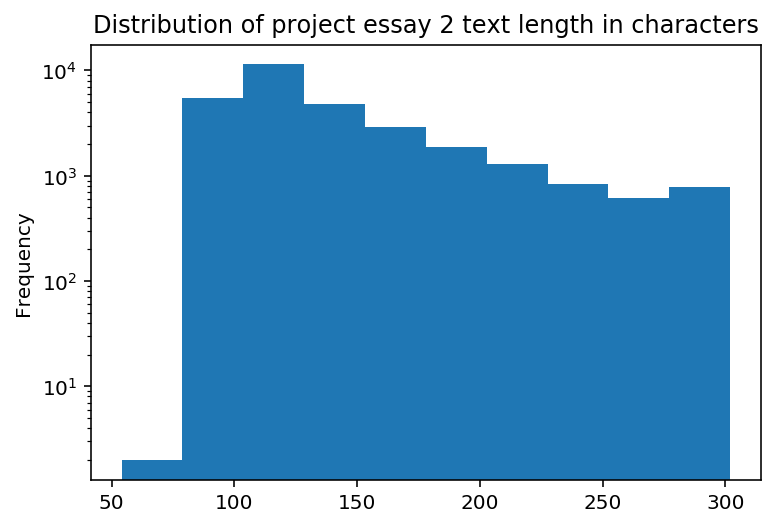

In [11]:
smaller_df['project_essay_2'].apply(lambda x: len(x.split())).plot(kind='hist');
plt.yscale('log');
plt.title('Distribution of project essay 2 text length in characters');

In [12]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 30 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count", palette=("YlGnBu_d"))
    ax.set(ylabel = 'Count')
    plt.xticks(rotation=45)
    plt.show()

<Figure size 432x288 with 0 Axes>

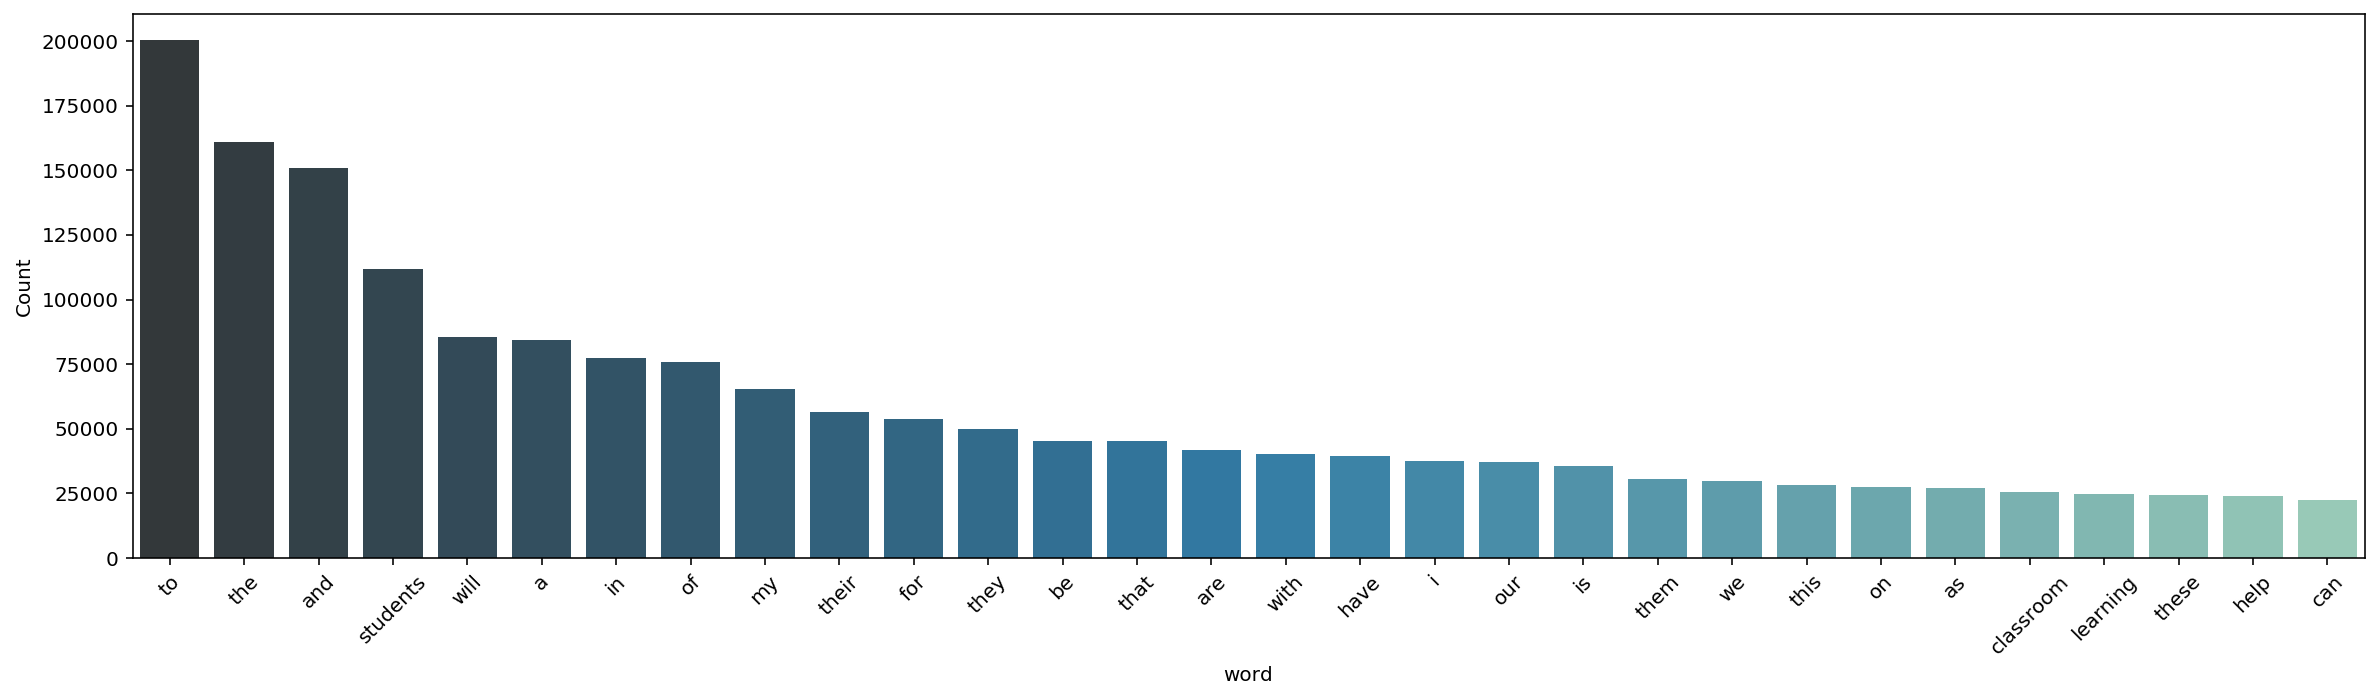

In [13]:
plt.savefig('title1.svg', transparent=True, bbox_inches='tight')
freq_words(smaller_df['project_essay_2'])

In [14]:
tokenized_reviews = pd.Series(smaller_df.project_essay_2).apply(lambda x: x.split())
print(tokenized_reviews)

0        [i, currently, have, a, differentiated, sight,...
1        [we, strive, to, provide, our, diverse, popula...
2        [we, are, looking, to, add, some, to, our, cla...
3        [the, students, project, which, is, totally, k...
4        [for, some, reason, in, our, kitchen, the, wat...
                               ...                        
29995    [each, child, is, special, and, different, the...
29996    [my, students, will, be, able, to, listen, to,...
29997    [my, students, are, serious, about, learning, ...
29998    [this, food, will, allow, us, to, kickstart, o...
29999    [these, full, body, mirrors, will, be, used, i...
Name: project_essay_2, Length: 30000, dtype: object


In [15]:
import spacy

nlp = spacy.load('en', disable=['parser', 'ner'])

def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output

In [16]:
essay_2 = lemmatization(tokenized_reviews)
essay_2[0] # print lemmatized review

['differentiated',
 'sight',
 'word',
 'center',
 'literacy',
 'station',
 'student',
 'activity',
 'sight',
 'word',
 'list',
 'favorite',
 'station',
 'activity',
 'student',
 'way',
 'sight',
 'word',
 'rnrni',
 'dream',
 'student',
 'reader',
 'sight',
 'word',
 'ipod',
 'sight',
 'word',
 'many',
 'student',
 'multiple',
 'exposure',
 'word',
 'student',
 'sight',
 'word',
 'flashcard',
 'ipod',
 'way',
 'sight',
 'word',
 'daily',
 'basis']

In [17]:
def dummy(doc):
    return doc

### Topic Modeling on Essay 2

In [18]:
# Create a CountVectorizer for parsing/counting words
count_vectorizer = CountVectorizer(ngram_range=(1, 2), 
                                   stop_words=stop_words, token_pattern="\\b[a-z][a-z]+\\b", tokenizer=dummy,preprocessor=dummy,
                                   min_df=0.1, max_df=0.8)

#count_vectorizer.fit(essay_2)

In [19]:
data_vectorized = count_vectorizer.fit_transform(essay_2)

/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'b', 'c', 'e', 'f', 'g', 'h', 'j', 'k', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [20]:
data_vectorized.shape

(30000, 37)

In [21]:
#Transform our sparse_data to corpus for gensim
corpus_data_gensim = gensim.matutils.Sparse2Corpus(data_vectorized, documents_columns=False)

In [22]:
#Create dictionary for LDA model
vocabulary_gensim = {}
for key, val in count_vectorizer.vocabulary_.items():
    vocabulary_gensim[val] = key
    
dict = Dictionary()
dict.merge_with(vocabulary_gensim)

### LDA

In [23]:
# Create lda model (equivalent to "fit" in sklearn)
# Creating the object for LDA model using gensim library
#LDA = gensim.models.ldamodel.LdaModel

lda = LdaModel(corpus = corpus_data_gensim, id2word=dict, num_topics=15, random_state=100,
                chunksize=100, passes=2)

In [24]:
lda.print_topics()

[(0,
  '0.273*"level" + 0.260*"need" + 0.160*"tool" + 0.147*"experience" + 0.094*"day" + 0.064*"technology" + 0.002*"good" + 0.000*"fun" + 0.000*"different" + 0.000*"access"'),
 (1,
  '0.273*"life" + 0.256*"world" + 0.208*"opportunity" + 0.137*"level" + 0.126*"good" + 0.000*"time" + 0.000*"different" + 0.000*"work" + 0.000*"access" + 0.000*"day"'),
 (2,
  '0.291*"class" + 0.268*"important" + 0.199*"technology" + 0.117*"life" + 0.082*"good" + 0.044*"experience" + 0.000*"work" + 0.000*"time" + 0.000*"day" + 0.000*"different"'),
 (3,
  '0.369*"math" + 0.338*"reading" + 0.286*"student able" + 0.007*"good" + 0.000*"level" + 0.000*"time" + 0.000*"different" + 0.000*"work" + 0.000*"access" + 0.000*"day"'),
 (4,
  '1.000*"year" + 0.000*"level" + 0.000*"work" + 0.000*"access" + 0.000*"good" + 0.000*"life" + 0.000*"day" + 0.000*"time" + 0.000*"experience" + 0.000*"able"'),
 (5,
  '0.632*"school" + 0.197*"book" + 0.056*"student able" + 0.026*"level" + 0.025*"good" + 0.023*"way" + 0.022*"access" +

In [25]:
#Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, corpus_data_gensim, dict)
pyLDAvis.save_html(vis, 'lda2.html')
vis

/anaconda3/envs/metis/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13    -0.251018 -0.096059       1        1  11.583606
5      0.049375 -0.127298       2        1   9.567699
9     -0.077359 -0.265387       3        1   9.562065
0     -0.205277  0.131293       4        1   9.435308
8      0.137162 -0.062466       5        1   7.806423
12    -0.167117 -0.248633       6        1   7.742701
11     0.169502  0.116027       7        1   6.786661
1     -0.141075  0.230117       8        1   6.397027
2     -0.206073  0.189239       9        1   6.265786
6      0.069345  0.242784      10        1   5.952763
14     0.148816 -0.113282      11        1   5.210804
7      0.187069  0.026457      12        1   4.998498
3      0.160208 -0.036534      13        1   4.879016
4      0.207485  0.032736      14        1   3.224758
10    -0.081042 -0.018993      15        1   0.586895, topic_info=   Category          Freq      Term         Total  loglift  logprob
3   Default  18294.000000    school  18294.000000  30.0000  30.0000
0   Default  16254.000000  activity  16254.000000  29.0000  29.0000
26  Default  13466.000000     skill  13466.000000  28.0000  28.0000
20  Default   9769.000000      year   9769.000000  27.0000  27.0000
17  Default  10239.000000     small  10239.000000  26.0000  26.0000
..      ...           ...       ...           ...      ...      ...
4   Topic15     47.825916       day  11195.136719  -0.3176  -3.6109
3   Topic15     47.825916    school  18294.826172  -0.8087  -3.6109
31  Topic15     47.825916     level  11425.812500  -0.3380  -3.6109
30  Topic15     47.825916     great  11317.081055  -0.3284  -3.6109
26  Topic15     47.825916     skill  13466.413086  -0.5023  -3.6109

[550 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
7        10  0.989264    able
7        15  0.010583    able
36        1  0.840875  access
36        2  0.065251  access
36        6  0.089024  access
...     ...       ...     ...
24       15  0.003023    work
11        8  0.990171   world
11       15  0.009627   world
20       14  0.995064    year
20       15  0.004913    year

[113 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 6, 10, 1, 9, 13, 12, 2, 3, 7, 15, 8, 4, 5, 11])

In [26]:
def document_to_lda_features(lda_model, document):
    topic_importances = lda.get_document_topics(document, minimum_probability=0)
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]

lda_features = list(map(lambda doc:document_to_lda_features(lda, doc),corpus_data_gensim))

In [27]:
data_pd_lda_features = pd.DataFrame(lda_features)
data_pd_lda_features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.011111,0.427714,0.011111,0.011111,0.011111,0.011111,0.427841,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111
1,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.266667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.516666,0.016667
2,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.177778,0.214653,0.011111,0.011111,0.163722,0.321625,0.011111
3,0.004444,0.071110,0.004444,0.004444,0.004444,0.004444,0.404445,0.004444,0.004444,0.004444,0.004444,0.004444,0.083145,0.392411,0.004444
4,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667


In [28]:
data_pd_lda_features.columns = [f'{c}_essay_2_topic' for c in data_pd_lda_features]

In [34]:
data_pd_lda_features.shape

(30000, 15)

In [30]:
y_train = smaller_df['project_is_approved'].values

/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


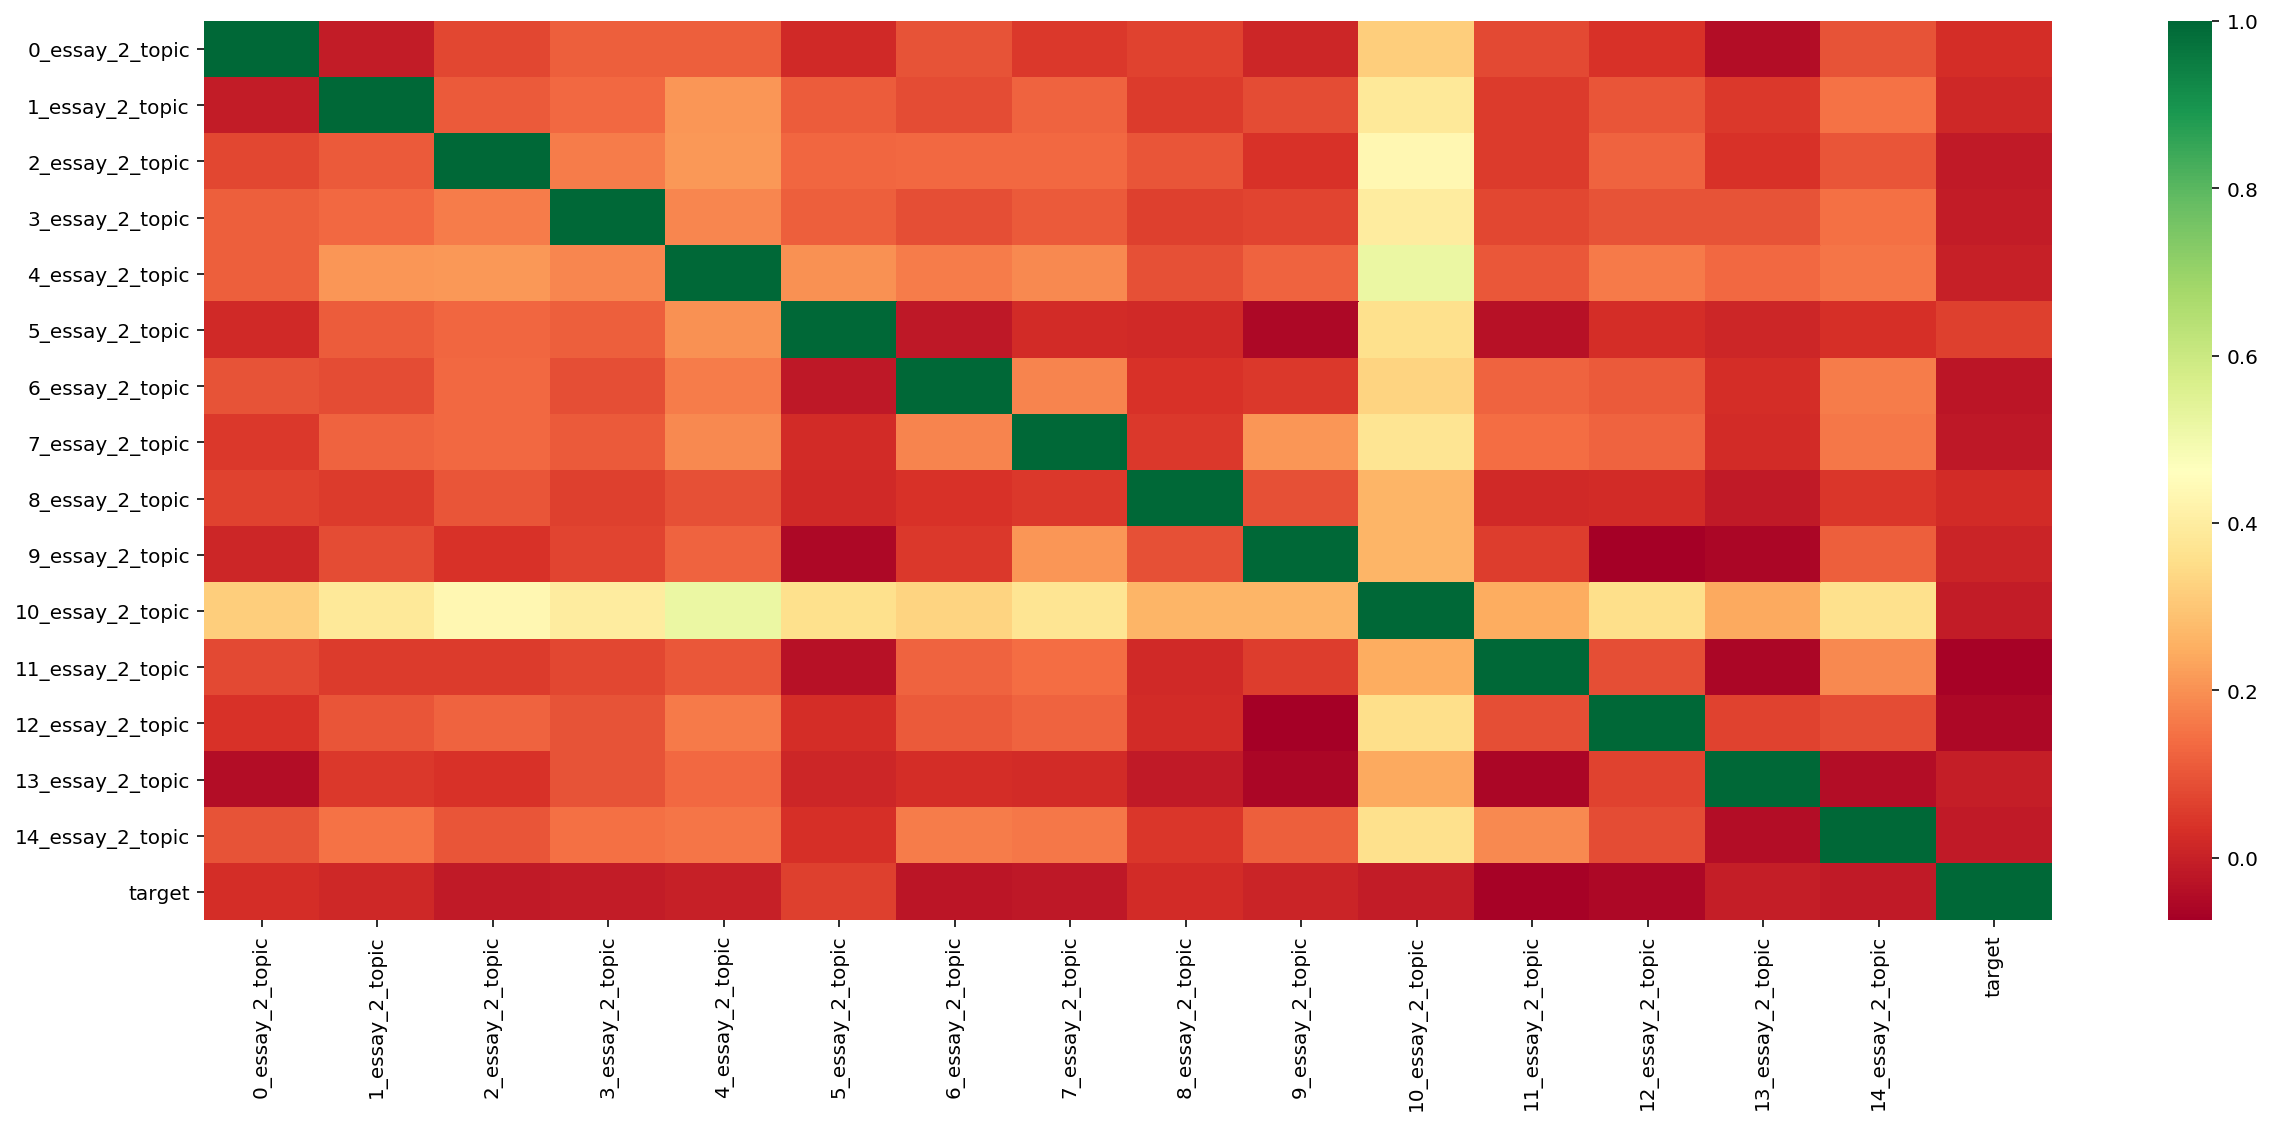

In [31]:
data_pd_lda_features_train = data_pd_lda_features.iloc[:y_train.shape[0]]
data_pd_lda_features_train['target'] = y_train

fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(20.7, 8.27)
ax = sns.heatmap(data_pd_lda_features_train.corr(method = 'spearman'), cmap="RdYlGn", ax = ax)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5) #to fix the cutting off on top/bottom
plt.savefig('essay2_correlation_matrix.svg', transparent=True, bbox_inches='tight')

In [33]:
data_pd_lda_features_train.to_pickle("./lda2_df.pkl")